# Test case definition:

In [1]:
import openturns as ot
import openturns.viewer
import openturns.viewer as viewer
import numpy as np
import pandas as pd
from matplotlib import pylab as plt

ot.Log.Show(ot.Log.NONE)

The goal of this workflow is to develop two modules for the deterministic sizing exercise that needs to be performed, for which the reliability analysis shall be performed to calculate the probability of failure of the SDP clip.
- First, a quantile function shall be developed to calculate the A or B-basis of the probability distribution of the material properties & the limit loads (LL) of the static loading condition distribution.
- Second, a translator function shall be developed to translate the design variables (n_var = 4) obtained from the optimization process in pymoo, to the one usable for as input to the SDP clip analytical function. The translator shall retrieve all the inputs required for the SDP analytical function from the design variables and other variables are set to nominal (bolt location and pattern is fixed, we shall choose a straight line as our bolting line along X-axis)

# Quantile Function

LLX for P: 1e-5 =  9446.828640978441
LLY for P: 1e-5 =  9446.828640978441


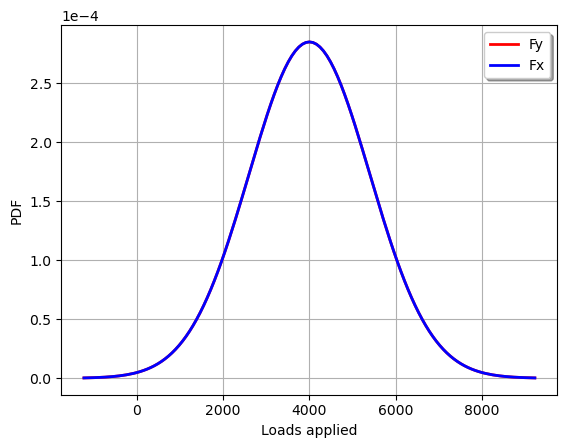

In [2]:
#material property bounds for allowables: bearing allowable for clip is needed only for optimal sizing, and bolt allowables
#for tension and shear
"""LOADS INPUT DISTRIBUTION----------------------------------------------------------"""
#nominal input loads:
Fx = 4000
Fy = 4000

cov_load = 35/100 # 35 & 5 percent
cov_all = 5/100

#defined loading bounds (only needed when uniformly distributed):
#Fx_bound = (10/100) #%
#Fy_bound = (10/100) #%

"""SIGMA = Mean * Cov"""

#loads distributions:
applied_force_distribution = [ot.Normal(Fx, Fx*cov_load), ot.Normal(Fy, Fy*cov_load)]
#[ot.Uniform(-0.01 + Fx*(1-Fx_bound), 0.01 + Fx*(1+Fx_bound)), ot.Uniform(-0.01 + Fy*(1-Fy_bound), 0.01 + Fy*(1+Fy_bound))]


loadX_distribution = applied_force_distribution[0]
loadY_distribution = applied_force_distribution[1]

LLX = loadX_distribution.computeQuantile(1-(1/20000))[0]
LLY = loadY_distribution.computeQuantile(1-(1/20000))[0]
print("LLX for P: 1e-5 = ", (LLX))
print("LLY for P: 1e-5 = ", (LLY))

graph1 = loadX_distribution.drawPDF()
graph1.setColors(["blue"])
graph1.setLegends(["Fx"])

#view = viewer.View(graph1)

graph2 = loadY_distribution.drawPDF()
graph2.setXTitle("Loads applied")
graph2.setLegends(["Fy"])

graph2.add(graph1)
#view = viewer.View(graph2)


#graph2.setYTitle("PDF")
#graph2.setTitle("Probability density function of the standard gaussian distribution")


view = viewer.View(graph2)

 # cov = 35%, Probability that an aircraft reaches LL in its lifetime = 1/20000 (Poccurence)

In [3]:
ULX = loadX_distribution.computeQuantile(1-(1e-9))[0]
ULY = loadY_distribution.computeQuantile(1-(1e-9))[0]
print("ULX for P: 1e-9 = ", (ULX))
print("ULY for P: 1e-9 = ", (ULY))
print("UL/LL X and Y: ", ULX/LLX, ULY/LLY)

# Typically UL/LL is 1.5. We should aim it to be higher from what we calculated!

ULX for P: 1e-9 =  12396.929827844988
ULY for P: 1e-9 =  12396.929827844988
UL/LL X and Y:  1.3122848205449182 1.3122848205449182


In [4]:
ULX2 = loadX_distribution.computeQuantile(1-(1e-12))[0]
ULY2 = loadY_distribution.computeQuantile(1-(1e-12))[0]
print("ULX2 for P: 1e-11 = ", (ULX2))
print("ULY2 for P: 1e-11 = ", (ULY2))
print("UL/LL X and Y: ", ULX2/LLX, ULY2/LLY)

# Typically UL/LL is 1.5. We should aim it to be higher from what we calculated!

ULX2 for P: 1e-11 =  14710.879330109376
ULY2 for P: 1e-11 =  14710.879330109376
UL/LL X and Y:  1.5572294035584113 1.5572294035584113


B-basis of clip bearing allowable =  798.0581837079225
B-basis of bolt shear allowable =  638.446546966338
B-basis of bolt tension allowable =  851.262062621784


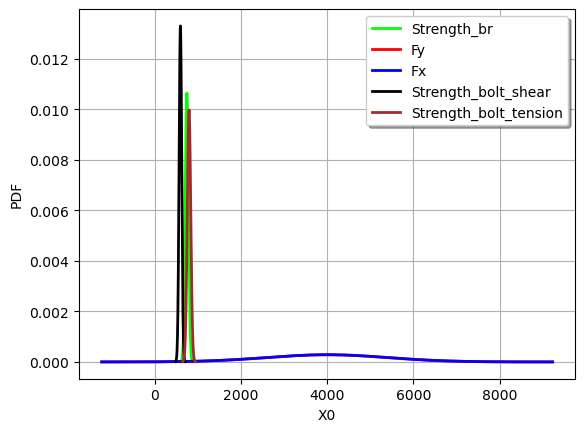

In [5]:
"""ALLOWABLES INPUT DISTRIBUTION----------------------------------------------------------"""
#allowable values input:
flat_ext_bearing_allowables_clip_frame_fuselage = np.array([750, 750, 750]).flatten()
flat_ext_shear_allowables_bolt = 600
flat_ext_tension_allowables_bolt = 800

#defined bounds:
#bolt_all_bound = 10/100 #%
#bearing_p1p2p3_bound = 10/100 #%

#defined distributions:
bearing_p123_allowables_distribution = [ot.Normal(k, k*cov_all) for k in flat_ext_bearing_allowables_clip_frame_fuselage.tolist()]
#[ot.Uniform(i*(1-bearing_p1p2p3_bound), i*(1+bearing_p1p2p3_bound)) for i in flat_ext_bearing_allowables_clip_frame_fuselage.tolist()]

shear_allowables_distribution = [ot.Normal(j, j*cov_all) for j in [flat_ext_shear_allowables_bolt]]
#[ot.Uniform(i*(1-bolt_all_bound), i*(1+bolt_all_bound)) for i in [flat_ext_shear_allowables_bolt]]

tension_allowables_distribution = [ot.Normal(i, i*cov_all) for i in [flat_ext_tension_allowables_bolt]]
#[ot.Uniform(i*(1-bolt_all_bound), i*(1+bolt_all_bound)) for i in [flat_ext_tension_allowables_bolt]]

#A-basis = 99%, B-basis = 90%

percentage = 90/100

#give the qualtile calculator a distribution, and the percentage at which it shall calculate the quantile
clip_allowables_distribution = bearing_p123_allowables_distribution[0] #we shall take only clip bearing
bolt_shear_allowables_distribution = shear_allowables_distribution
bolt_tension_allowables_distribution = tension_allowables_distribution



B_val_clip = clip_allowables_distribution.computeQuantile(percentage)[0]
B_val_bolt_shear = bolt_shear_allowables_distribution[0].computeQuantile(percentage)[0]
B_val_bolt_tension = bolt_tension_allowables_distribution[0].computeQuantile(percentage)[0]



print('B-basis of clip bearing allowable = ', (B_val_clip))
print('B-basis of bolt shear allowable = ', (B_val_bolt_shear))
print('B-basis of bolt tension allowable = ', (B_val_bolt_tension))


graph_clip_all = clip_allowables_distribution.drawPDF()
graph_clip_all.setColors(["green"])
graph_clip_all.setLegends(["Strength_br"])
graph_clip_all.add(graph2)



graph_b_shear = bolt_shear_allowables_distribution[0].drawPDF()
graph_b_shear.setColors(["black"])
graph_b_shear.setLegends(["Strength_bolt_shear"])

graph_clip_all.add(graph_b_shear)



graph_b_tension = tension_allowables_distribution[0].drawPDF()
graph_b_tension.setColors(["brown"])
graph_b_tension.setLegends(["Strength_bolt_tension"])

graph_clip_all.add(graph_b_tension)
view = viewer.View(graph_clip_all)

# yielding allowable, we use LL
# rupture allowable, we use UL
# check with Airbus folks for bolts, clip, check if we used UL or LL. UL is a stricter criteria.

So, the above function from openturns allows for the computation of the quantile (x %) from a distribution we supply to it.
Okay, now that we have the qualtile calculator, we shall implement it on our two distributions: loads and material properties.
- loads, to calculate LL
- material properties, to calculate B-basis

What is a B-basis? It is the allowable value above which at least 90% of the population values will fall with 95% confidence levels.

Why B-basis? Because we have an assembly with redundant pathways, a fail-safe design, which means, if a member fails (eg a bolt), the loads get redistributed safely around the adjacent members (other bolts), so we can use B-basis as our allowable strength to size the structure deterministically. (Source: NIU Stress Analysis, Chapter 04)

Finally, above, we have the input block where distributions are defined with their bounds, for loads and material properties. Nothing shall change in this block. And then we have the qualtile calculator. This block calculates the LL from the loading distributions, and the B-basis for the clip bearing allowables only. 

# Translation & Assembly Process

Now, comes the translation process. What we shall develop here is a function or an algorithm that shall allow the retrieval of all the inputs of the SDP clip analytical (that long list!) from the design variable information from the pymoo optimal design process.
- What do we have from pymoo? The design variables: [nfw, nff, thickness, diameter]
- nfw and nff = number of fasteners in the web and foot respectively. We have nfw = NNinp and nff = NNinpfoot in our SDP code.
- thickness is for clip, which is part 1 as per definition, 2 and 3 are frame and fuselage skin resp. So we have tp1 = t 
- diameter is the diameter value of the bolt. Since we shall use all bolts of the same design and material, same bolts on web and foot, we have d = [diameter]*nfw and dfoot = [diameter]*nff

# Implementation of the Translator:
Converting pymoo optimal design point into openturns compatible input.

In [6]:
"""INPUT TRANSLATOR:"""
# x comes from pymoo!
from translator_module import translator
from sdp_clip_module_v2_updated import sdp_clip_analytical_function_v2

load_case = 3

Fx_inp = [Fx, LLX, ULX, ULX2, 1.5*Fx][load_case-1]
Fy_inp = [Fy, LLY, ULY, ULY2, 1.5*Fy][load_case-1]

#fixed design parameters
length = 120 #parallel to the web
# e = 2.  #distance between holes and edges
# p = 2.  #distance between holes
web_height = 80 #vertical
foot_height = 70 #horizontal
density = 0.00000271 #kg/m3
all_frame_br = flat_ext_bearing_allowables_clip_frame_fuselage[1]
all_fuselage_br = flat_ext_bearing_allowables_clip_frame_fuselage[2]
bolt_K = 15
t_p2, t_p3 = 2, 3
# Loads input: LLX, LLY or ULX, ULY

def translated_model(x):
    from translator_module import translator
    SDP_Clip_Analytical_Inputs = translator(x, length, web_height, foot_height, Fx_inp, Fy_inp, B_val_clip , 
                                            B_val_bolt_shear, B_val_bolt_tension , 
                                            all_frame_br, all_fuselage_br, 
                                            bolt_K, t_p2, t_p3)
    # the translator throws out re-constructed inputs in the form of a list!
    RFs = sdp_clip_analytical_function_v2(SDP_Clip_Analytical_Inputs)
    # 
    return RFs, SDP_Clip_Analytical_Inputs
print("load_case = ", load_case, ";", Fx_inp, Fy_inp)

load_case =  3 ; 12396.929827844988 12396.929827844988


In [7]:
inputtemp = translated_model({'nfw': 4, 'dfw': 6.5, 'nff': 3, 't': 2})
print("inp1", inputtemp[0])
print("inp2", inputtemp[1])
print("============================================================================")
from sdp_clip_module_v2_printing_updated import sdp_clip_analytical_function_v2_printing
sdp_clip_analytical_function_v2_printing(inputtemp[1])

inp1 [2.1616696962836204, 1.0585801746627015, 0.9948336439684888, 5.126849841915494, 2.510643328374752, 3.5391827338936377, 6.835746254881326]
inp2 [24,48,72,96,40,40,40,40,30,60,90,35,35,35,15,15,15,15,15,15,15,6.5,6.5,6.5,6.5,6.5,6.5,6.5,2,2,3,60,0,12396.9,12396.9,798.058,750,750,638.45,851.26,4,3]#42
locbvec [24. 48. 72. 96. 40. 40. 40. 40.]
foot_locbvec [30. 60. 90. 35. 35. 35.]
applied loads; Fxinp =  12396.929827844988 Fyinp =  12396.929827844988
------------------------------------WEB--------------------------------------------
Stiffness Kb =  [15. 15. 15. 15.]
web LocF =  [60.  0.]
bolt_location_xi =  [24. 48. 72. 96.]
bolt_location_yi =  [40. 40. 40. 40.]
locbTT  [[24. 48. 72. 96.]
 [40. 40. 40. 40.]]
bolt locations =  [[24. 40.]
 [48. 40.]
 [72. 40.]
 [96. 40.]] <class 'numpy.ndarray'>
------------------------------------FOOT--------------------------------------------
Stiffness Kb =  [15. 15. 15.]
foot_locbvec =  [30. 60. 90. 35. 35. 35.] <class 'numpy.ndarray'>
foot_bolt_lo

[2.1616696962836204,
 1.0585801746627015,
 0.9948336439684888,
 5.126849841915494,
 2.510643328374752,
 3.5391827338936377,
 6.835746254881326]

# Pymoo NSGA2 Mixed Variable Multi-Objective Optimization Operation Block:


### Define a Termination Criterion¶

Furthermore, a termination criterion needs to be defined to start the optimization procedure. Most common ways of defining the termination is by limiting the overall number of function evaluations or simply the number of iterations of the algorithm. Moreover, some algorithms already have implemented their own, for instance Nelder-Mead when the simplex becomes degenerated or CMA-ES where a vendor library is used. Because of the simplicity of this problem we use a rather small number of 40 iteration of the algorithm.

In [8]:
from pymoo.core.mixed import MixedVariableGA
from pymoo.core.variable import Real, Integer
from pymoo.optimize import minimize
from numpy import pi
from pymoo.core.problem import ElementwiseProblem


#categorical variables
#this is where the choices are defined, discrete domain from which
#the design variables will select their values during optimization
l_nfw = [4, 5, 6, 8] #no of fasteners in the web
l_dfw = [4.5, 5., 5.5]  #mm #diameter of fasteners
l_nff = [5, 6, 7] #no of fasteners in the foot

class MultiObjectiveMixedVariableProblem(ElementwiseProblem):
    # Choice(options=[(0.5)*i + 0.5 for i in range(0, 6)])
    def __init__(self):
        vars = {
            "nfw": Integer(bounds=(4, 8)),
            "dfw": Choice(options=[4.5, 5, 5.5]),
            "nff": Integer(bounds=(5, 7)),
            "t": Real(bounds=(0.1, 3))
        }
        super().__init__(
                         vars=vars,
                         n_obj=2,
                         n_ieq_constr = 7
                        )

    def _evaluate(self, x, out, *args, **kwargs):
        
        #x is the input vector, from which we extract 4 key values of design parameters:
        nfw, dfw, nff, t = int(x['nfw']), x['dfw'], int(x['nff']), x['t']
        
        #required values are extracted ready to use in the objective & constraint functions:
        # fitness functions
        # Mass function:
        f1 = density * t * ((length * (web_height + foot_height) - pi * (nfw +nff) * dfw**2/4.) + 
                            (1.3 * (1 + 5 / t) * pi * (nfw + nff) * dfw**2/4)) * 1000.
        # cost function (drilled surface):
        f2 = pi * ((nfw * dfw ** 2 / 4.) + (nff * dfw ** 2 / 4.)) 
        
        
        #ISAE Analytical formulation, except for the last one (simplified)
        #constraints:
                       
        # bearing (bolts with loads applied in shear and bearing, t/D ratio, bearing or the shear limit depends on the load)
        #gc = [translated_model(x)[0][i] - 1 for i in range(nfw*3 + nff*4)]
        g1 = 1 - translated_model(x)[0][0]
        g2 = 1 - translated_model(x)[0][1]
        g3 = 1 - translated_model(x)[0][2]
        g4 = 1 - translated_model(x)[0][3]
        g5 = 1 - translated_model(x)[0][4]
        g6 = 1 - translated_model(x)[0][5]
        g7 = 1 - translated_model(x)[0][6]
        #g8 = Fy_inp / (sigma_y * (length - nfw*dfw) * t) - 1. 
        
        
        """# bypass: netsurface/net section
        g1 = Fy / (nfw * dfw * t * Fby) - 1
        
        # bypass: netsurface/net section
        g2 = Fy / (sigma_y * (length - nfw*dfw) * t) - 1.
        
        # shear (allowable for fasteners)
        g3 = Fy / (Fsu * nfw * pi * (dfw**2) / 4.) - 1.
         
        #tensile limit for the fasteners in the foot (horiz)
        g4 = Fy / (nff * pi * (dfw**2) * Fsu_rivet / 4.) - 1.
        """
        
        #we define the dictionary of the outputs of the discipline
        out["F"] = [f1, f2]
        out["G"] = [g1, g2, g3, g4, g5, g6, g7]

from pymoo.visualization.scatter import Scatter
from pymoo.algorithms.moo.nsga2 import RankAndCrowdingSurvival
from pymoo.core.mixed import MixedVariableGA
from pymoo.optimize import minimize

problem2 = MultiObjectiveMixedVariableProblem()

algorithm2 = MixedVariableGA(pop_size=500, survival=RankAndCrowdingSurvival())

res2 = minimize(problem2,
               algorithm2,
               ('n_gen', 30),
               seed=1,
               verbose=True)

plot = Scatter()
plot.add(problem2.pareto_front(), plot_type="line", color="black", alpha=0.7)
plot.add(res2.F, facecolor="none", edgecolor="red")
plot.show()

In [9]:
from pymoo.core.variable import Real, Integer, Choice
from numpy import pi

from pymoo.visualization.scatter import Scatter
from pymoo.algorithms.moo.nsga2 import NSGA2, RankAndCrowdingSurvival
from pymoo.core.mixed import MixedVariableMating, MixedVariableGA, MixedVariableSampling, MixedVariableDuplicateElimination
from pymoo.optimize import minimize

problem3 = MultiObjectiveMixedVariableProblem()
pop_size=200
algorithm3 = NSGA2(pop_size,
                  sampling=MixedVariableSampling(),
                  mating=MixedVariableMating(eliminate_duplicates=MixedVariableDuplicateElimination()),
                  eliminate_duplicates=MixedVariableDuplicateElimination(),
                  )
n_gen = 20
res3 = minimize(problem3,
               algorithm3,
               ('n_gen', n_gen),
               seed=1,
               verbose=True)

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |      200 |      7 |  0.000000E+00 |  0.3869315469 |             - |             -
     2 |      400 |     10 |  0.000000E+00 |  0.0273659131 |  0.0464688295 |         ideal
     3 |      600 |      8 |  0.000000E+00 |  0.000000E+00 |  0.2624254680 |         nadir
     4 |      800 |      6 |  0.000000E+00 |  0.000000E+00 |  0.0138931575 |         ideal
     5 |     1000 |      7 |  0.000000E+00 |  0.000000E+00 |  0.4517927409 |         nadir
     6 |     1200 |      6 |  0.000000E+00 |  0.000000E+00 |  0.0334510958 |         ideal
     7 |     1400 |      6 |  0.000000E+00 |  0.000000E+00 |  0.0829525940 |         ideal
     8 |     1600 |      6 |  0.000000E+00 |  0.000000E+00 |  0.0042094489 |             f
     9 |     1800 |      6 |  0.000000E+00 |  0.000000E+00 |  0.0109630041 |         ideal
    10 |     2000 |      5 |  0.000000E+00 |  0.000000E+00 |  0.0031078646 |         nadir

### NOTE: for the above table when verbose=True
If the verbose=True, some printouts during the algorithm’s execution are provided. This can very from algorithm to algorithm. Here, we execute NSGA2 on a problem where pymoo has no knowledge about the optimum. Each line represents one iteration. The first two columns are the current generation counter and the number of evaluations so far. For constrained problems, the next two columns show the minimum constraint violation (cv (min)) and the average constraint violation (cv (avg)) in the current population. This is followed by the number of non-dominated solutions (n_nds) and two more metrics which represents the movement in the objective space.

## PCP plot works when all vars have either bounds or options:

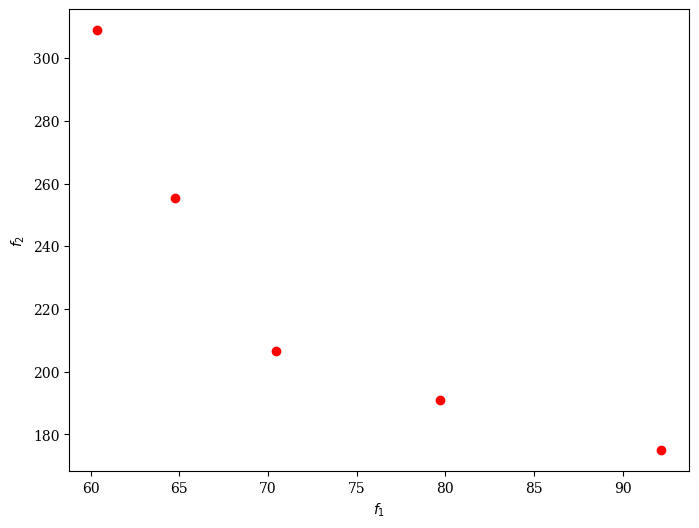

In [10]:
plot = Scatter()
plot.add(problem3.pareto_front(), plot_type="line", color="black", alpha=0.7)
plot.add(res3.F, facecolor="red", edgecolor="red")
plot.show()
plt.savefig("Pareto_with_UL.png")

# Translating Pymoo Optimal Design Output to OT compatible Form:

In [11]:
pymoo_design_solutions = (res3.X)
print(pymoo_design_solutions)
"""We collect all the outputs of the deterministic design procedure here!"""

[{'nfw': 6, 'nff': 5, 'dfw': 4.5, 't': 1.8209719696966467}
 {'nfw': 8, 'nff': 5, 'dfw': 4.5, 't': 1.3649080746269058}
 {'nfw': 8, 'nff': 5, 'dfw': 5.0, 't': 1.2307096980036092}
 {'nfw': 8, 'nff': 5, 'dfw': 5.5, 't': 1.1206824179865882}
 {'nfw': 7, 'nff': 5, 'dfw': 4.5, 't': 1.5601108208892083}]


'We collect all the outputs of the deterministic design procedure here!'

In [12]:
res3.F

array([[ 92.16771283, 174.9474409 ],
       [ 70.45165505, 206.75606651],
       [ 64.78572451, 255.2544031 ],
       [ 60.38882393, 308.85782776],
       [ 79.70613014, 190.85175371]])

In [13]:
"""we input the det design solutions to the translated model to give out ultimately the RFs for each design solution"""
print([np.round(translated_model(pymoo_design_solutions[i])[0]) for i in range(len(pymoo_design_solutions))])

[array([2., 1., 1., 4., 3., 4., 5.]), array([2., 1., 1., 4., 2., 4., 5.]), array([3., 1., 2., 5., 2., 5., 7.]), array([3., 1., 2., 6., 2., 5., 8.]), array([2., 1., 1., 4., 2., 4., 5.])]


In [14]:
"""since our translated model returns SDP inputs assembled for OT compatible function as well, we here print the SDP input
lists for each of the design solutions obtained obtained from the translated_model function."""
#([translated_model(pymoo_design_solutions[i])[1] for i in range(len(pymoo_design_solutions))])

'since our translated model returns SDP inputs assembled for OT compatible function as well, we here print the SDP input\nlists for each of the design solutions obtained obtained from the translated_model function.'

# PythonFunction:

In [15]:
from sdp_clip_module_v2_reliability_updated import sdp_clip_analytical_function_v2_reliability
"""sdp_clip_analytical_function_v2_reliability function returns this:
lis2 = [min(RF_bolt_shear), min(RF_clip_bearing), min(RF_frame_bearing), min(foot_RF_bolt_shear), 
min(foot_RF_clip_bearing), min(foot_RF_fuselage_bearing), min(foot_RF_bolt_tension)]
GG = lis2
return [min(GG)]"""
NNlist = []
NNfootlist = []
#OT_sdp_clip_analytical_function_list = []

for i in range(len(pymoo_design_solutions)):
    NNlist = np.append(NNlist, int(pymoo_design_solutions[i]['nfw']))
    NNfootlist = np.append(NNfootlist, int(pymoo_design_solutions[i]['nff']))
    #OT_sdp_clip_analytical_function_list = np.append(OT_sdp_clip_analytical_function_list, ot.PythonFunction((NNlist[i] + NNfootlist[i])*4 + 14, 1, sdp_clip_analytical_function_v2_reliability))
    #print("Input big list = ", input_for_SDP_reliability)
    #print('OT_sdp_clip_analytical_function', OT_sdp_clip_analytical_function)
    
NNlist, NNfootlist

(array([6., 8., 8., 8., 7.]), array([5., 5., 5., 5., 5.]))

# Test Reliability Function Block to get reliabilities of all pareto solutions:

In [16]:
pymoo_design_solutions = (res3.X)
print(pymoo_design_solutions)

[{'nfw': 6, 'nff': 5, 'dfw': 4.5, 't': 1.8209719696966467}
 {'nfw': 8, 'nff': 5, 'dfw': 4.5, 't': 1.3649080746269058}
 {'nfw': 8, 'nff': 5, 'dfw': 5.0, 't': 1.2307096980036092}
 {'nfw': 8, 'nff': 5, 'dfw': 5.5, 't': 1.1206824179865882}
 {'nfw': 7, 'nff': 5, 'dfw': 4.5, 't': 1.5601108208892083}]


# This following block is not threshold reliability calculations, remember to remove all other uncertainties to get the threshold values for each design solution:

In [17]:
def Pf_MCS_stage1(x):
    import openturns as ot
    import openturns.viewer
    import openturns.viewer as viewer
    from sdp_clip_module_v2_updated import sdp_clip_analytical_function_v2
    from sdp_clip_module_v2_printing_updated import sdp_clip_analytical_function_v2_printing
    import numpy as np
    import pandas as pd
    from matplotlib import pylab as plt

    ot.Log.Show(ot.Log.NONE)


    # The goal of this workflow is to develop two modules for the deterministic sizing exercise that needs to be performed, for which the reliability analysis shall be performed to calculate the probability of failure of the SDP clip.
    # - First, a quantile function shall be developed to calculate the A or B-basis of the probability distribution of the material properties & the limit loads (LL) of the static loading condition distribution.
    # - Second, a translator function shall be developed to translate the design variables (n_var = 4) obtained from the optimization process in pymoo, to the one usable for as input to the SDP clip analytical function. The translator shall retrieve all the inputs required for the SDP analytical function from the design variables and other variables are set to nominal (bolt location and pattern is fixed, we shall choose a straight line as our bolting line along X-axis)

    
    """INPUT TRANSLATOR:"""
    # x comes from pymoo!


    from translator_module import translator
    from sdp_clip_module_v2_updated import sdp_clip_analytical_function_v2
    # grabs inputs from the deterministic results:
    input_for_translated_model = x
    print("x = ", input_for_translated_model)
    NNinp = input_for_translated_model['nfw']
    NNinpfoot = input_for_translated_model['nff']

    geo_tol_xy = 1       #mm
    Kb_bound = (10/100)  #%
    xF_poa_bound = 1      #mm for location
    yF_poa_bound = 1      #mm for location

    Fx_bound = (10/100) #%
    Fy_bound = (10/100) #%
    bolt_all_bound = 10/100 #%
    bearing_p1p2p3_bound = 10/100 #%
    """Input sample size for SOBOL SA"""
    inp_sample_size = 10000


    # Input Distributions here:
    # already defined during quantile calculation on the top:
    
    NN = NNinp
    NNfoot = NNinpfoot
    input_for_SDP_reliability = translated_model(x)[1]
    SDP_Clip_Analytical_Input = np.array(input_for_SDP_reliability)
    
    """MAIN INPUT FOR UQ: Number of output parameters considered for inputing distributions!"""
    """
    Level 1: All geometric tolerancing uncertainties
    Level 2: loading & env uncertainties
    Level 3: material-level uncertainties
    Level 4: Full Game!
    """
    """RESOLUTION 2 June 2023"""

    """===================DEFINING DISTRIBUTIONS==============================="""
    flat_bolt_location = SDP_Clip_Analytical_Input[0:NN*2]
    flat_foot_bolt_location = SDP_Clip_Analytical_Input[NN*2:(NN*2 + NNfoot*2)]

    flat_bolt_stiffness = SDP_Clip_Analytical_Input[(NN*2 + NNfoot*2):(NN*3 + NNfoot*2)]
    flat_foot_bolt_stiffness = SDP_Clip_Analytical_Input[(NN*3 + NNfoot*2):(NN*3 + NNfoot*3)]

    flat_bolt_diameter = SDP_Clip_Analytical_Input[(NN*3 + NNfoot*3):(NN*4 + NNfoot*3)]
    flat_foot_bolt_diameter = SDP_Clip_Analytical_Input[(NN*4 + NNfoot*3):(NN*4 + NNfoot*4)]

    flat_sdp_clip_thickness_p1 = SDP_Clip_Analytical_Input[(NN*4 + NNfoot*4)]
    flat_frame_thickness_p2 = SDP_Clip_Analytical_Input[(NN*4 + NNfoot*4) + 1]
    flat_frame_thickness_p3 = SDP_Clip_Analytical_Input[(NN*4 + NNfoot*4) + 2]

    flat_force_poa = SDP_Clip_Analytical_Input[(NN*4 + NNfoot*4) + 3:(NN*4 + NNfoot*4) + 5]
    
    # this small adhoc line for xF only works if all the bolts are of same stiffness and size or dia. which is the case, hence
    xF = length/2 #(NNinpfoot-1)*p/2 + e
    yF = 0
    
    
    
    force_poa_distribution = [ot.Uniform(xF-xF_poa_bound, xF+xF_poa_bound),  
                              ot.Uniform(yF-yF_poa_bound, yF+yF_poa_bound)]


    bolt_loc_distribution = [ot.Uniform(-geo_tol_xy+i, i+geo_tol_xy) for i in flat_bolt_location.tolist()]
    foot_bolt_loc_distribution = [ot.Uniform(-geo_tol_xy+i, i+geo_tol_xy) for i in flat_foot_bolt_location.tolist()]

    bolt_stiffness_distribution = [ot.Uniform(i*(1-Kb_bound), i*(1+Kb_bound)) for i in flat_bolt_stiffness.tolist()] 
    foot_bolt_stiffness_distribution = [ot.Uniform(i*(1-Kb_bound), i*(1+Kb_bound)) for i in flat_foot_bolt_stiffness.tolist()] 
    #bolt_dia_distribution = [ot.Uniform(0.9*i, i*1.1) for i in flat_bolt_diameter.tolist()] #*NNinp
    """------------------------------------------------------------------------------"""
    #t1t2_distribution = [ot.Uniform(0.9*flat_sdp_clip_thickness_p1, flat_sdp_clip_thickness_p1*1.1),ot.Uniform(0.9*flat_frame_thickness_p2, flat_frame_thickness_p2*1.1)]
    #t1 is frozen to the design solution!!
    """AUTOMATED DISTRIBUTION INPUT"""


    """================================Select the Level of Uncertainty Analysis for SDP Clip====================================="""

    
    Uncertainty_Case = "deterministic sizing"
    #print("ORIGINAL SDP_Clip_Analytical_Input = ", SDP_Clip_Analytical_Input)
    match Uncertainty_Case:
        case "deterministic sizing":
            indices = list(range(0, (NNinp + NNinpfoot)*4 + 5)) + list(range((NNinp + NNinpfoot)*4 + 12, (NNinp*4 + NNinpfoot*4) + 14))
            referencePoint = list(SDP_Clip_Analytical_Input[:(NNinp*4 + NNinpfoot*4) + 5]) + list(SDP_Clip_Analytical_Input[(NNinp + NNinpfoot)*4 + 12:])
            #print("referencePoint = ", referencePoint)
            inputDistribution = ot.ComposedDistribution(applied_force_distribution +
                                                        bearing_p123_allowables_distribution +
                                                        shear_allowables_distribution + 
                                                        tension_allowables_distribution)
            # print('indices = ', indices)
            input_names = ['Fx', 'Fy', 'allowable_bearing_clip_p1', 'allowable_bearing_frame_p2', 'allowable_bearing_fuselage_p3', 'allowable_shear_bolt', 'allowable_tension_bolt']
    #print(len(indices) == len(referencePoint))
    #print(len(indices), '+', len(input_names), "=", len(indices) + len(input_names))


    # NOTE: Here in the following block of code, the function 'sdp_clip_analytical_function_v2_reliability' 
    # gives out the minimum RF of the RF list from the model.

    # In[13]:
    

    from sdp_clip_module_v2_reliability_updated import sdp_clip_analytical_function_v2_reliability


    OT_sdp_clip_analytical_function = ot.PythonFunction((NNinp + NNinpfoot)*4 + 14, 1, sdp_clip_analytical_function_v2_reliability)
    

    # We shall now parameterize the function to include the remaining inputs at their nominal values and the loads at LIMIT LOAD and materials properties at B-BASES.


    OT_parametric_sdp = ot.ParametricFunction(OT_sdp_clip_analytical_function, indices, referencePoint)
    #print(OT_parametric_sdp)


    #print(inputDistribution)
    function = OT_parametric_sdp


    # # The reliability of the optimal design:
    # Limit State Function & Monte Carlo Simulation:

    # In[14]:


    limitStateFunction = function
    #limitStateFunction


    # In[15]:


    myDistribution = inputDistribution
    #myDistribution


    # In[16]:


    inputRandomVector = ot.RandomVector(myDistribution)
    #print(inputRandomVector)


    outputRandomVector = ot.CompositeRandomVector(limitStateFunction, inputRandomVector)
    #outputRandomVector


    # In[17]:


    myEvent = ot.ThresholdEvent(outputRandomVector, ot.Less(), 1.0)
    #myEvent


    # In[18]:


    sampleSize = 10000
    sampleG = outputRandomVector.getSample(sampleSize)

    sampleSize = 500
    sampleG = outputRandomVector.getSample(sampleSize)
    graph = ot.HistogramFactory().build(sampleG).drawPDF()
    view = viewer.View(graph)
    
    cv = 0.05 ## Coefficient of variation
    NbSim = 100000
    # Create a Monte Carlo algorithm:
    experiment = ot.MonteCarloExperiment()
    algoMC = ot.ProbabilitySimulationAlgorithm(myEvent, experiment)
    algoMC.setMaximumOuterSampling(NbSim)
    algoMC.setBlockSize(1)
    algoMC.setMaximumCoefficientOfVariation(cv)


    # In[21]:


    initialNumberOfCall = limitStateFunction.getEvaluationCallsNumber()


    # In[22]:


    algoMC.run()


    # In[23]:


    result = algoMC.getResult()
    probabilityMonteCarlo = result.getProbabilityEstimate()
    numberOfFunctionEvaluationsMonteCarlo = (
        limitStateFunction.getEvaluationCallsNumber() - initialNumberOfCall
    )
    #print("Number of calls to the limit state =", numberOfFunctionEvaluationsMonteCarlo)
    print("Pf = ", probabilityMonteCarlo)
    #print("CV =", result.getCoefficientOfVariation())


    # In[24]:


    #graph = algoMC.drawProbabilityConvergence()
    #graph.setLogScale(ot.GraphImplementation.LOGX)
    #view = viewer.View(graph)

    alpha = 0.05
    pflen = result.getConfidenceLength(1 - alpha)
    #print("%.2f%% confidence interval = [%f,%f]" % ((1 - alpha) * 100, probabilityMonteCarlo - pflen / 2, probabilityMonteCarlo + pflen / 2))
    return probabilityMonteCarlo

x =  {'nfw': 6, 'nff': 5, 'dfw': 4.5, 't': 1.8209719696966467}
Pf =  0.004282908083854911
x =  {'nfw': 8, 'nff': 5, 'dfw': 4.5, 't': 1.3649080746269058}
Pf =  0.0042297417631344935
x =  {'nfw': 8, 'nff': 5, 'dfw': 5.0, 't': 1.2307096980036092}
Pf =  0.0041747318859534565
x =  {'nfw': 8, 'nff': 5, 'dfw': 5.5, 't': 1.1206824179865882}
Pf =  0.004219900160758068
x =  {'nfw': 7, 'nff': 5, 'dfw': 4.5, 't': 1.5601108208892083}
Pf =  0.0042911069765440785


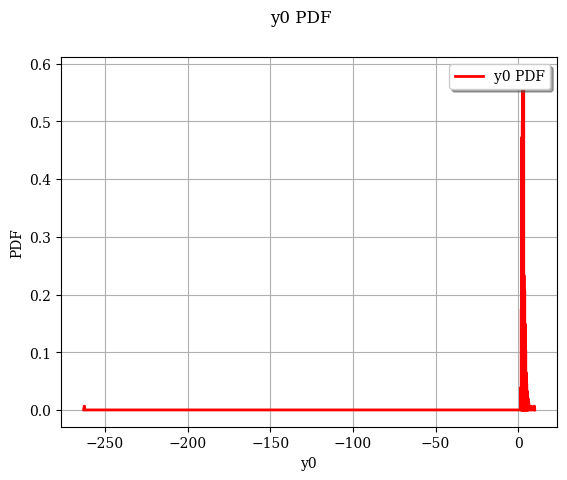

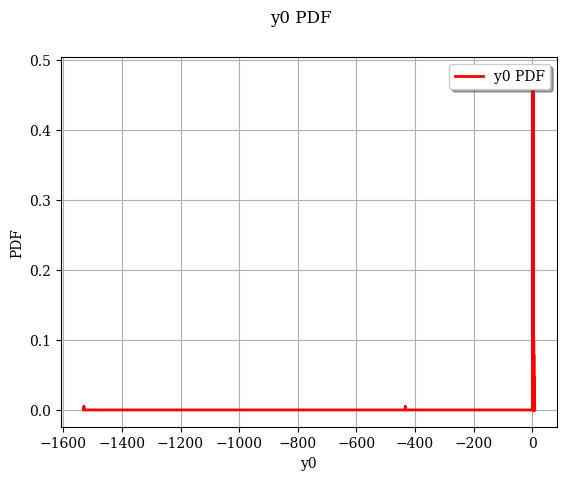

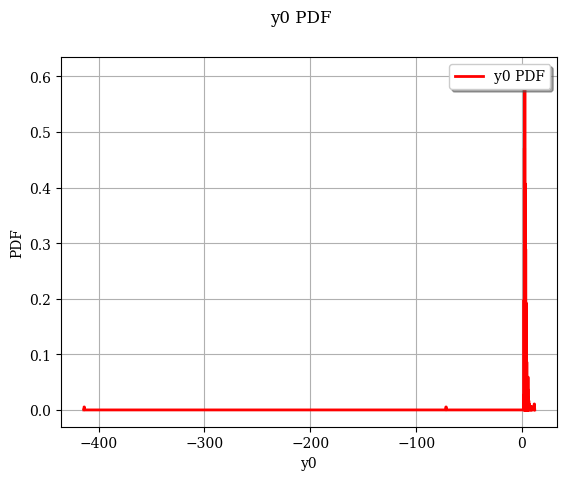

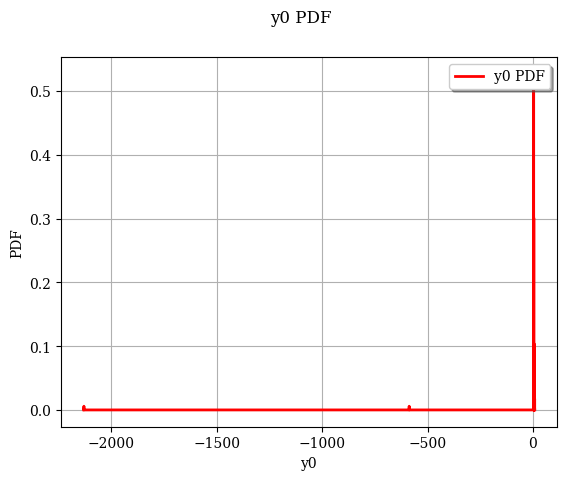

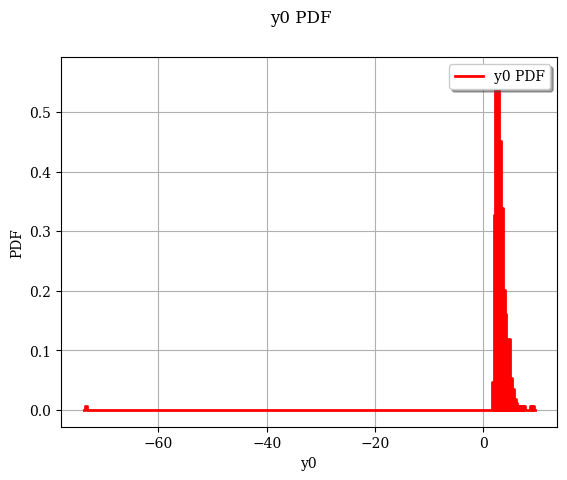

In [18]:
Pf1 = []

for i in range(len(pymoo_design_solutions)):
    #print(Pf_MCS_threshold(pymoo_design_solutions[i]))
    Pf1 = np.append(Pf1, Pf_MCS_stage1(pymoo_design_solutions[i]))
   

In [19]:
Pf1

array([0.00428291, 0.00422974, 0.00417473, 0.0042199 , 0.00429111])

In [20]:
Reliability1 = 1 - Pf1
print(Reliability1)

[0.99571709 0.99577026 0.99582527 0.9957801  0.99570889]


# Reliability of the joint with added uncertainties:

In [21]:
# uncertainty level = 5 all uncertainties except geometric
def Pf_MCS_stage2(x):
    import openturns as ot
    import openturns.viewer
    import openturns.viewer as viewer
    from sdp_clip_module_v2_updated import sdp_clip_analytical_function_v2
    from sdp_clip_module_v2_printing_updated import sdp_clip_analytical_function_v2_printing
    import numpy as np
    import pandas as pd
    from matplotlib import pylab as plt

    ot.Log.Show(ot.Log.NONE)


    # The goal of this workflow is to develop two modules for the deterministic sizing exercise that needs to be performed, for which the reliability analysis shall be performed to calculate the probability of failure of the SDP clip.
    # - First, a quantile function shall be developed to calculate the A or B-basis of the probability distribution of the material properties & the limit loads (LL) of the static loading condition distribution.
    # - Second, a translator function shall be developed to translate the design variables (n_var = 4) obtained from the optimization process in pymoo, to the one usable for as input to the SDP clip analytical function. The translator shall retrieve all the inputs required for the SDP analytical function from the design variables and other variables are set to nominal (bolt location and pattern is fixed, we shall choose a straight line as our bolting line along X-axis)

    
    """INPUT TRANSLATOR:"""
    # x comes from pymoo!


    from translator_module import translator
    from sdp_clip_module_v2_updated import sdp_clip_analytical_function_v2
    # grabs inputs from the deterministic results:
    input_for_translated_model = x
    print("x = ", input_for_translated_model)
    NNinp = input_for_translated_model['nfw']
    NNinpfoot = input_for_translated_model['nff']

    geo_tol_xy = 1       #mm
    Kb_bound = (10/100)  #%
    xF_poa_bound = 1      #mm for location
    yF_poa_bound = 1      #mm for location

    #Fx_bound = (10/100) #%
    #Fy_bound = (10/100) #%
    #bolt_all_bound = 10/100 #%
    #bearing_p1p2p3_bound = 10/100 #%
    """Input sample size for SOBOL SA"""
    #inp_sample_size = 10000


    # Input Distributions here:
    # already defined during quantile calculation on the top:
    """applied_force_distribution
    bearing_p123_allowables_distribution
    shear_allowables_distribution
    tension_allowables_distribution"""
    NN = NNinp
    NNfoot = NNinpfoot
    input_for_SDP_reliability = translated_model(x)[1]
    SDP_Clip_Analytical_Input = np.array(input_for_SDP_reliability)
    
    """MAIN INPUT FOR UQ: Number of output parameters considered for inputing distributions!"""
    """
    Level 1: All geometric tolerancing uncertainties
    Level 2: loading & env uncertainties
    Level 3: material-level uncertainties
    Level 4: Full Game!
    """
    """RESOLUTION 2 June 2023"""

    """===================DEFINING DISTRIBUTIONS==============================="""



    flat_bolt_location = SDP_Clip_Analytical_Input[0:NN*2]
    flat_foot_bolt_location = SDP_Clip_Analytical_Input[NN*2:(NN*2 + NNfoot*2)]

    flat_bolt_stiffness = SDP_Clip_Analytical_Input[(NN*2 + NNfoot*2):(NN*3 + NNfoot*2)]
    flat_foot_bolt_stiffness = SDP_Clip_Analytical_Input[(NN*3 + NNfoot*2):(NN*3 + NNfoot*3)]

    flat_bolt_diameter = SDP_Clip_Analytical_Input[(NN*3 + NNfoot*3):(NN*4 + NNfoot*3)]
    flat_foot_bolt_diameter = SDP_Clip_Analytical_Input[(NN*4 + NNfoot*3):(NN*4 + NNfoot*4)]

    flat_sdp_clip_thickness_p1 = SDP_Clip_Analytical_Input[(NN*4 + NNfoot*4)]
    flat_frame_thickness_p2 = SDP_Clip_Analytical_Input[(NN*4 + NNfoot*4) + 1]
    flat_frame_thickness_p3 = SDP_Clip_Analytical_Input[(NN*4 + NNfoot*4) + 2]

    flat_force_poa = SDP_Clip_Analytical_Input[(NN*4 + NNfoot*4) + 3:(NN*4 + NNfoot*4) + 5]
    
    # this small adhoc line for xF only works if all the bolts are of same stiffness and size or dia. which is the case, hence
    xF = length/2
    yF = 0
    
    
    
    force_poa_distribution = [ot.Uniform(xF-xF_poa_bound, xF+xF_poa_bound),  
                              ot.Uniform(yF-yF_poa_bound, yF+yF_poa_bound)]


    bolt_loc_distribution = [ot.Uniform(-geo_tol_xy+i, i+geo_tol_xy) for i in flat_bolt_location.tolist()]
    foot_bolt_loc_distribution = [ot.Uniform(-geo_tol_xy+i, i+geo_tol_xy) for i in flat_foot_bolt_location.tolist()]

    bolt_stiffness_distribution = [ot.Uniform(i*(1-Kb_bound), i*(1+Kb_bound)) for i in flat_bolt_stiffness.tolist()] 
    foot_bolt_stiffness_distribution = [ot.Uniform(i*(1-Kb_bound), i*(1+Kb_bound)) for i in flat_foot_bolt_stiffness.tolist()] 
    #bolt_dia_distribution = [ot.Uniform(0.9*i, i*1.1) for i in flat_bolt_diameter.tolist()] #*NNinp
    """------------------------------------------------------------------------------"""
    #t1t2_distribution = [ot.Uniform(0.9*flat_sdp_clip_thickness_p1, flat_sdp_clip_thickness_p1*1.1),ot.Uniform(0.9*flat_frame_thickness_p2, flat_frame_thickness_p2*1.1)]
    #t1 is frozen to the design solution!!
    """AUTOMATED DISTRIBUTION INPUT"""


    """================================Select the Level of Uncertainty Analysis for SDP Clip====================================="""

    
    Uncertainty_Case = "Kb+POA"
    #print("ORIGINAL SDP_Clip_Analytical_Input = ", SDP_Clip_Analytical_Input)
    match Uncertainty_Case:
        #1
        case "All geometric tolerancing uncertainties":
            #print("SOBOL SA for Case: X-Y Bolt location geometric tolerancing uncertainties")
            indices = list(range(2*(NNinp + NNinpfoot), 4*(NNinp + NNinpfoot) + 14))
            #print('indices = ', indices)
            referencePoint = list(SDP_Clip_Analytical_Input[2*(NNinp + NNinpfoot):])
            #print("referencePoint = ", referencePoint)
            inputDistribution = ot.ComposedDistribution(bolt_loc_distribution + foot_bolt_loc_distribution)
            input_names = ['X'+str(i+1) for i in range(NNinp)] + ['Y'+str(i+1) for i in range(NNinp)] + ['Xf'+str(i+1) for i in range(NNinpfoot)]  + ['Yf'+str(i+1) for i in range(NNinpfoot)]
        #2
        case "loading & env uncertainties":
            #print("SOBOL SA for Case: loading & env uncertainties")
            indices = list(range(0, (NNinp + NNinpfoot)*4 + 3)) + list(range((NNinp + NNinpfoot)*4 + 7, (NNinp*4 + NNinpfoot*4) + 14))
            referencePoint = list(SDP_Clip_Analytical_Input[:(NNinp*4 + NNinpfoot*4) + 3]) + list(SDP_Clip_Analytical_Input[(NNinp + NNinpfoot)*4 + 7:])
            #print("referencePoint = ", referencePoint)
            inputDistribution = ot.ComposedDistribution(force_poa_distribution + applied_force_distribution)
            #print('indices = ', indices)
            input_names = ['xF', 'yF', 'Fx', 'Fy']
        #3
        case "material-level uncertainties":
            #print("SOBOL SA for Case: material-level uncertainties")
            indices = list(range(0, (NNinp+NNinpfoot)*2)) + list(range((NNinp+NNinpfoot)*3, (NNinp + NNinpfoot)*4 + 7)) + list(range((NNinp*4 + NNinpfoot*4) + 12, (NNinp*4 + NNinpfoot*4) + 14))
            referencePoint = list(SDP_Clip_Analytical_Input[0:(NNinp+NNinpfoot)*2]) + list(SDP_Clip_Analytical_Input[(NNinp+NNinpfoot)*3 : (NNinp + NNinpfoot)*4 + 7]) + list(SDP_Clip_Analytical_Input[(NNinp*4 + NNinpfoot*4) + 12:])
            #print("referencePoint = ", referencePoint)
            inputDistribution = ot.ComposedDistribution(bolt_stiffness_distribution + 
                                                        foot_bolt_stiffness_distribution +
                                                        bearing_p123_allowables_distribution +
                                                        shear_allowables_distribution + 
                                                        tension_allowables_distribution)
            input_names = ['Kb'+str(i+1) for i in range(NNinp)] + ['Kbfoot'+str(i+1) for i in range(NNinpfoot)] + ['allowable_bearing_clip_p1', 'allowable_bearing_frame_p2', 'allowable_bearing_fuselage_p3', 'allowable_shear_bolt', 'allowable_tension_bolt']

            #4
        case "ALL UNCERTAINTIES!":
            #print("SOBOL SA for Case: ALL UNCERTAINTIES!")
            indices = list(range(3*(NNinp+NNinpfoot), 4*(NNinp+NNinpfoot)+3)) + list(range((NNinp*4 + NNinpfoot*4) + 12, (NNinp*4 + NNinpfoot*4) + 14))
            referencePoint = list(SDP_Clip_Analytical_Input[3*(NNinp+NNinpfoot): 4*(NNinp+NNinpfoot)+3]) + [NNinp, NNinpfoot]
            #print("referencePoint = ", referencePoint)
            #print('indices = ', indices)
            inputDistribution = ot.ComposedDistribution(bolt_loc_distribution +
                                                        foot_bolt_loc_distribution +
                                                        bolt_stiffness_distribution +
                                                        foot_bolt_stiffness_distribution +
                                                        force_poa_distribution +
                                                        applied_force_distribution +
                                                        bearing_p123_allowables_distribution +
                                                        shear_allowables_distribution + 
                                                        tension_allowables_distribution)
            input_names = ['X'+str(i+1) for i in range(NNinp)] + ['Y'+str(i+1) for i in range(NNinp)] + ['Xfoot'+str(i+1) for i in range(NNinpfoot)] + ['Yfoot'+str(i+1) for i in range(NNinpfoot)] + ['Kb'+str(i+1) for i in range(NNinp)] + ['Kbfoot'+str(i+1) for i in range(NNinpfoot)] + ['xF', 'yF', 'Fx', 'Fy', 'allowable_bearing_clip_p1', 'allowable_bearing_frame_p2', 'allowable_bearing_fuselage_p3', 'allowable_shear_bolt', 'allowable_tension_bolt']
        #5
        case "deterministic sizing":
            indices = list(range(0, (NNinp + NNinpfoot)*4 + 5)) + list(range((NNinp + NNinpfoot)*4 + 12, (NNinp*4 + NNinpfoot*4) + 14))
            referencePoint = list(SDP_Clip_Analytical_Input[:(NNinp*4 + NNinpfoot*4) + 5]) + list(SDP_Clip_Analytical_Input[(NNinp + NNinpfoot)*4 + 12:])
            #print("referencePoint = ", referencePoint)
            inputDistribution = ot.ComposedDistribution(applied_force_distribution +
                                                        bearing_p123_allowables_distribution +
                                                        shear_allowables_distribution + 
                                                        tension_allowables_distribution)
            # print('indices = ', indices)
            input_names = ['Fx', 'Fy', 'allowable_bearing_clip_p1', 'allowable_bearing_frame_p2', 'allowable_bearing_fuselage_p3', 'allowable_shear_bolt', 'allowable_tension_bolt']
        
        case "Kb+POA":
            #print("SOBOL SA for Case: ALL UNCERTAINTIES!")
            indices = list(range(0, 2*(NNinp+NNinpfoot))) + list(range(3*(NNinp+NNinpfoot), 4*(NNinp+NNinpfoot)+3)) + list(range((NNinp*4 + NNinpfoot*4) + 12, (NNinp*4 + NNinpfoot*4) + 14))
            referencePoint = list(SDP_Clip_Analytical_Input[:2*(NNinp+NNinpfoot)]) + list(SDP_Clip_Analytical_Input[3*(NNinp+NNinpfoot): 4*(NNinp+NNinpfoot)+3]) + [NNinp, NNinpfoot]
            #print("referencePoint = ", referencePoint)
            #print('indices = ', indices)
            inputDistribution = ot.ComposedDistribution(bolt_stiffness_distribution +
                                                        foot_bolt_stiffness_distribution +
                                                        force_poa_distribution +
                                                        applied_force_distribution +
                                                        bearing_p123_allowables_distribution +
                                                        shear_allowables_distribution + 
                                                        tension_allowables_distribution)
            input_names = ['Kb'+str(i+1) for i in range(NNinp)] + ['Kbfoot'+str(i+1) for i in range(NNinpfoot)] + ['xF', 'yF', 'Fx', 'Fy', 'allowable_bearing_clip_p1', 'allowable_bearing_frame_p2', 'allowable_bearing_fuselage_p3', 'allowable_shear_bolt', 'allowable_tension_bolt']
        #5
    
    

    from sdp_clip_module_v2_reliability_updated import sdp_clip_analytical_function_v2_reliability


    OT_sdp_clip_analytical_function = ot.PythonFunction((NNinp + NNinpfoot)*4 + 14, 1, sdp_clip_analytical_function_v2_reliability)
    

    # We shall now parameterize the function to include the remaining inputs at their nominal values and the loads at LIMIT LOAD and materials properties at B-BASES.


    OT_parametric_sdp = ot.ParametricFunction(OT_sdp_clip_analytical_function, indices, referencePoint)
    #print(OT_parametric_sdp)


    #print(inputDistribution)
    function = OT_parametric_sdp


    # # The reliability of the optimal design:
    # Limit State Function & Monte Carlo Simulation:

    # In[14]:


    limitStateFunction = function
    #limitStateFunction


    # In[15]:


    myDistribution = inputDistribution
    #myDistribution


    # In[16]:


    inputRandomVector = ot.RandomVector(myDistribution)
    #print(inputRandomVector)


    outputRandomVector = ot.CompositeRandomVector(limitStateFunction, inputRandomVector)
    #outputRandomVector


    # In[17]:


    myEvent = ot.ThresholdEvent(outputRandomVector, ot.Less(), 1.0)
    #myEvent


    # In[18]:


    sampleSize = 10000
    sampleG = outputRandomVector.getSample(sampleSize)


    cv = 0.05 ## Coefficient of variation
    NbSim = 100000
    # Create a Monte Carlo algorithm:
    experiment = ot.MonteCarloExperiment()
    algoMC = ot.ProbabilitySimulationAlgorithm(myEvent, experiment)
    algoMC.setMaximumOuterSampling(NbSim)
    algoMC.setBlockSize(1)
    algoMC.setMaximumCoefficientOfVariation(cv)


    # In[21]:


    initialNumberOfCall = limitStateFunction.getEvaluationCallsNumber()


    # In[22]:


    algoMC.run()


    # In[23]:


    result = algoMC.getResult()
    probabilityMonteCarlo = result.getProbabilityEstimate()
    numberOfFunctionEvaluationsMonteCarlo = (
        limitStateFunction.getEvaluationCallsNumber() - initialNumberOfCall
    )
    #print("Number of calls to the limit state =", numberOfFunctionEvaluationsMonteCarlo)
    print("Pf = ", probabilityMonteCarlo)
    #print("CV =", result.getCoefficientOfVariation())


    # In[24]:


    #graph = algoMC.drawProbabilityConvergence()
    #graph.setLogScale(ot.GraphImplementation.LOGX)
    #view = viewer.View(graph)


    # In[25]:


    alpha = 0.05
    pflen = result.getConfidenceLength(1 - alpha)
    #print("%.2f%% confidence interval = [%f,%f]"% ((1 - alpha) * 100, probabilityMonteCarlo - pflen / 2, probabilityMonteCarlo + pflen / 2))
    return probabilityMonteCarlo

In [22]:
Pf2 = []

for i in range(len(pymoo_design_solutions)):
    #print(Pf_MCS_uncertainty(pymoo_design_solutions[i]))
    Pf2 = np.append(Pf2, Pf_MCS_stage2(pymoo_design_solutions[i]))

x =  {'nfw': 6, 'nff': 5, 'dfw': 4.5, 't': 1.8209719696966467}
Pf =  0.004652193176783386
x =  {'nfw': 8, 'nff': 5, 'dfw': 4.5, 't': 1.3649080746269058}
Pf =  0.004538164943528817
x =  {'nfw': 8, 'nff': 5, 'dfw': 5.0, 't': 1.2307096980036092}
Pf =  0.0042445002340325425
x =  {'nfw': 8, 'nff': 5, 'dfw': 5.5, 't': 1.1206824179865882}
Pf =  0.004373177842565604
x =  {'nfw': 7, 'nff': 5, 'dfw': 4.5, 't': 1.5601108208892083}
Pf =  0.0046930134086097105


In [23]:
#[0.004117774544103502, ]
Reliability2 = 1 - Pf2
print(Reliability2)

[0.99534781 0.99546184 0.9957555  0.99562682 0.99530699]


In [24]:
Pf2

array([0.00465219, 0.00453816, 0.0042445 , 0.00437318, 0.00469301])

In [25]:
delta_reliability = []
delta_Pfailures = []
for i in range(len(Reliability2)):
    delta_reliability = np.append(delta_reliability, (Reliability2[i] - Reliability1[i])*100/Reliability1[i])
    delta_Pfailures = np.append(delta_Pfailures, (Pf2[i] - Pf1[i])*100/Pf1[i])
    
print("delta_reliability = ", np.round(delta_reliability, 3))
print("delta_Pfailures = ", np.round(delta_Pfailures, 3))

delta_reliability =  [-0.037 -0.031 -0.007 -0.015 -0.04 ]
delta_Pfailures =  [8.622 7.292 1.671 3.632 9.366]


# END
# Below you can test any particular solution to see the actual distributions compared with each other on a single plot:

Fx =  4000.0 Fy =  4000.0
Fx =  4000.0 Fy =  4000.0


(None, None)

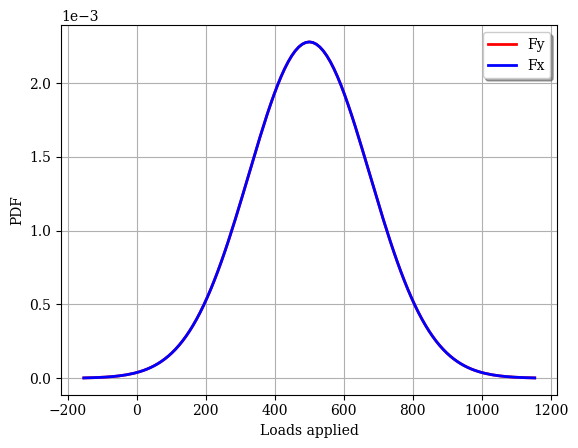

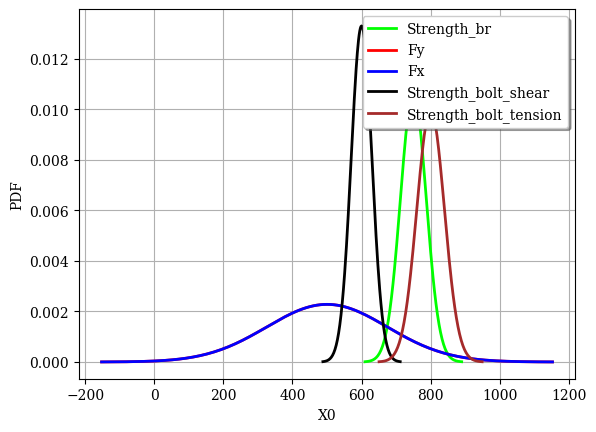

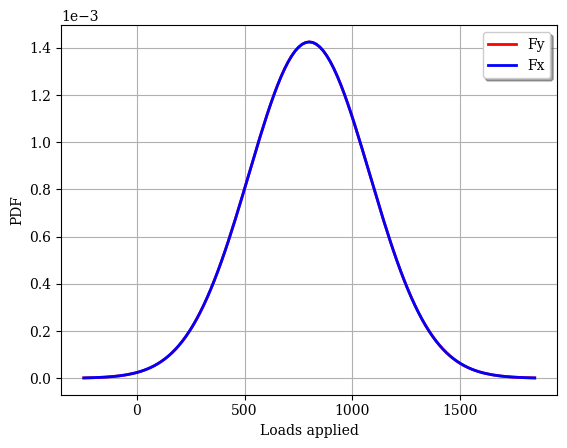

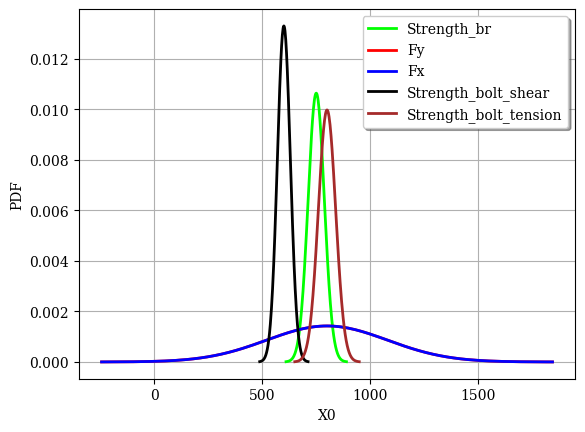

In [26]:
#material property bounds for allowables: bearing allowable for clip is needed only for optimal sizing, and bolt allowables
#for tension and shear
a_sol = {'nfw': 8, 'nff': 5, 'dfw': 5.0, 't': 0.9412691653369287}


"""LOADS INPUT DISTRIBUTION----------------------------------------------------------"""
#nominal input loads:
def plotter_ot(numb_bolts):
    Fx_dummy = 4000/numb_bolts
    Fy_dummy = 4000/numb_bolts
    print("Fx = ", Fx_dummy*numb_bolts, "Fy = ", Fy_dummy*numb_bolts)

    cov_load = 35/100 # 35 & 5 percent
    cov_all = 5/100

    #defined loading bounds (only needed when uniformly distributed):
    #Fx_bound = (10/100) #%
    #Fy_bound = (10/100) #%

    """SIGMA = Mean * Cov"""

    #loads distributions:
    applied_force_distribution = [ot.Normal(Fx_dummy, Fx_dummy*cov_load), ot.Normal(Fy_dummy, Fy_dummy*cov_load)]
    loadX_distribution = applied_force_distribution[0]
    loadY_distribution = applied_force_distribution[1]


    graph1 = loadX_distribution.drawPDF()
    graph1.setColors(["blue"])
    graph1.setLegends(["Fx"])

    #view = viewer.View(graph1)

    graph2 = loadY_distribution.drawPDF()
    graph2.setXTitle("Loads applied")
    graph2.setLegends(["Fy"])

    graph2.add(graph1)
    view = viewer.View(graph2)

    dummy_flat_ext_bearing_allowables_clip_frame_fuselage = np.array([750, 750, 750]).flatten()
    dummy_flat_ext_shear_allowables_bolt = 600
    dummy_flat_ext_tension_allowables_bolt = 800

    #defined distributions:
    dummy_bearing_p123_allowables_distribution = [ot.Normal(k, k*cov_all) for k in dummy_flat_ext_bearing_allowables_clip_frame_fuselage.tolist()]
    #[ot.Uniform(i*(1-bearing_p1p2p3_bound), i*(1+bearing_p1p2p3_bound)) for i in flat_ext_bearing_allowables_clip_frame_fuselage.tolist()]

    dummy_shear_allowables_distribution = [ot.Normal(j, j*cov_all) for j in [dummy_flat_ext_shear_allowables_bolt]]
    #[ot.Uniform(i*(1-bolt_all_bound), i*(1+bolt_all_bound)) for i in [flat_ext_shear_allowables_bolt]]

    dummy_tension_allowables_distribution = [ot.Normal(i, i*cov_all) for i in [dummy_flat_ext_tension_allowables_bolt]]
    #[ot.Uniform(i*(1-bolt_all_bound), i*(1+bolt_all_bound)) for i in [flat_ext_tension_allowables_bolt]]

    #give the qualtile calculator a distribution, and the percentage at which it shall calculate the quantile
    dummy_clip_allowables_distribution = dummy_bearing_p123_allowables_distribution[0] #we shall take only clip bearing
    dummy_bolt_shear_allowables_distribution = dummy_shear_allowables_distribution
    dummy_bolt_tension_allowables_distribution = dummy_tension_allowables_distribution

    graph_clip_all = dummy_clip_allowables_distribution.drawPDF()
    graph_clip_all.setColors(["green"])
    graph_clip_all.setLegends(["Strength_br"])
    graph_clip_all.add(graph2)



    graph_b_shear = dummy_bolt_shear_allowables_distribution[0].drawPDF()
    graph_b_shear.setColors(["black"])
    graph_b_shear.setLegends(["Strength_bolt_shear"])

    graph_clip_all.add(graph_b_shear)



    graph_b_tension = dummy_tension_allowables_distribution[0].drawPDF()
    graph_b_tension.setColors(["brown"])
    graph_b_tension.setLegends(["Strength_bolt_tension"])

    graph_clip_all.add(graph_b_tension)
    view = viewer.View(graph_clip_all)
    
plotter_ot(a_sol["nfw"]), plotter_ot(a_sol["nff"])

# Appendix Calculations 
Reliability of a Deterministically Optimized Design
Parameterizing the OT Function:

In [27]:
#creating a text file with the command function "x"

filename = "RDOD_UL_case.txt"


def save_value(input_value, filename):
    with open(filename, "w") as f:    
        f.write(input_value)
        f.close()
        
def append_value(input_value, filename):
    with open(filename, "a") as f:    
        f.write(input_value)
        f.close()

def load_value(filename):
    with open(filename, "r") as f:
        read = f.read()
    return read

save_value("\n----------------------\n", filename)
append_value("f1f2 results: \n"+str(res3.F), filename)

append_value("\n----------------------\n", filename)
append_value("x results: \n"+str(res3.X), filename)

append_value("\n----------------------\n", filename)
append_value("Load case = "+str([Fx_inp, Fy_inp])+"\n", filename)
append_value("cov_load & cov_all = "+str([cov_load, cov_all]), filename)


append_value("\n----------------------\n", filename)
append_value("Fixed design parameters:\n", filename)
append_value("length = "+str([length])+"\n", filename)
append_value("web & foot_height = "+str([web_height, foot_height])+"\n", filename)
append_value("rho = "+str([density])+"\n", filename)

append_value("\n----------------------\n", filename)
append_value("bearing_allowables_clip_frame_fuselage = "+str(flat_ext_bearing_allowables_clip_frame_fuselage)+"\n", filename)
append_value("shear_allowables_bolt = "+str(flat_ext_shear_allowables_bolt)+"\n", filename)
append_value("tension_allowables_bolt = "+str(flat_ext_tension_allowables_bolt)+"\n", filename)

append_value("\n----------------------\n", filename)
append_value('B-basis of clip bearing allowable = '+str(B_val_clip)+"\n", filename)
append_value('B-basis of bolt shear allowable = '+str(B_val_bolt_shear)+"\n", filename)
append_value('B-basis of bolt tension allowable = '+str(B_val_bolt_tension)+"\n", filename)

append_value("bolt stiffness = "+str([bolt_K])+"\n", filename)
append_value("tp2, tp3 = "+str([t_p2, t_p3])+"\n", filename)
append_value("\n----------------------\n", filename)

append_value("optimization design variables catalogues: \n"+"nfw, dfw, nff \n"+str([l_nfw, l_dfw, l_nff])+"\n", filename)
append_value("NSGA settings: pop_size & n_gen = "+str([pop_size, n_gen])+"\n", filename)
append_value("\n----------------------\n", filename)

append_value("Pf1 = "+str(Pf1)+"\n", filename)
append_value("Pf2 = "+str(Pf2)+"\n", filename)
append_value("Reliability1 = "+str(Reliability1)+"\n", filename)
append_value("Reliability2 = "+str(Reliability2)+"\n", filename)
append_value("delta_Pfailures% = "+str(np.round(delta_Pfailures, 4))+"\n", filename)
append_value("delta_reliability% = "+str(np.round(delta_reliability, 4))+"\n", filename)
append_value("\n----------------------\n", filename)

append_value("MCS sample size = "+str(10000)+"\n", filename)